# Set Up

## Import Libraries 

In [1]:
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
import datetime
from celluloid import Camera
import matplotlib.image as mpimg
import cv2

## Functions

In [6]:
def orientation_radians(nx, ny, tx, ty, y_max):
    """
    Calculates the orientation of the mouse with respect to the entire arena.
    If the mouse was pointing directly right, with the nose more right than the tail,
    the orientation would be 0. Orientation goes from 0 to 2pi as the mouse turns counter clockwise.

    Arguments:
    - nx (float): x-coordinate of the nose
    - ny (float): y-coordinate of the nose
    - tx (float): x-coordinate of the tailbase
    - ty (float): y-coordinate of the tailbase
    - y_max (float): maximum y-coordinate 

    Returns:
    - theta (float): angle of orientation in radians 
    - slope (float): slope of the line between the two selected points
    - xint  (float): x-intercept of the line between the two selected points
    """
    
    # Get the slope of the line between the nose and tailbase 
    slope = (ny - ty) / (nx - tx)
    # get the x-intercept of the line 
    xint = ((y_max - ny) / slope) + nx
    
    
    if ((nx > tx) and (ny < ty)):
        # if the nose is further to the right than the tailbase
        # and if the nose is higher than the tailbase
        length = nx - xint
        height = y_max - ny
        theta = math.atan(height/length)
    elif ((nx < tx) and (ny < ty)):
        # if the nose is further to the left than the tailbase
        # and if the nose is higher than the tailbase 
        length = xint - nx
        height = y_max - ny
        theta = math.pi - (math.atan(height/length))
    elif ((nx < tx) and (ny > ty)):
        # if the nose is further to the left than the tailbase
        # and if the nose is lower than the tailbase
        length = tx - xint
        height = y_max - ty
        theta = math.pi + (math.atan(height/length))
    elif ((nx > tx) and (ny > ty)):
        # if the nose if further to the right than the tailbase
        # and if the nose is lower than the tailbase
        length = xint - tx
        height = y_max - ty
        theta = (2*math.pi) - (math.atan(height/length))
    else:
        #print("Invalid nose and tail positions")
        theta = math.nan

    return theta, slope, xint

def orientation_horizontal(Rx, Ry, Lx, Ly, y_max):
    """
    Calculates the orientation of the mouse with respect to the entire arena.
    For when the user selected axis is between two points that lie on the same line horizontally 

    Arguments:
    - Rx (float): x-coordinate of the right point
    - Ry (float): y-coordinate of the right point
    - Lx (float): x-coordinate of the left point
    - Ly (float): y-coordinate of the left point
    - y_max (float): maximum y-coordinate 

    Returns:
    - theta (float): angle of orientation in radians
    - slope (float): slope of the line between the two selected points
    - xint  (float): x-intercept of the line between the two selected points
    """
    
    # Get the slope of the line between the nose and tailbase 
    slope = (Ry - Ly) / (Rx - Lx)
    # get the x-intercept of the line 
    xint = ((y_max - Ry) / slope) + Rx
    
    
    if ((Rx > Lx) and (Ry < Ly)):
        # if the right point is further to the right than the left point
        # and if the right point is higher than the left point
        length = Rx - xint
        height = y_max - Ry
        theta = math.atan(height/length)
    elif ((Rx < Lx) and (Ry < Ly)):
        # if the right point is further to the left than the left point 
        # and if the right point is higher than the left point 
        length = xint - Rx
        height = y_max - Ry
        theta = math.pi - (math.atan(height/length))
    elif ((Rx < Lx) and (Ry > Ly)):
        # if the right point is further to the left than the left point
        # and if the right point is lower than the left point
        length = Lx - xint
        height = y_max - Ly
        theta = math.pi + (math.atan(height/length))
    elif ((Rx > Lx) and (Ry > Ly)):
        # if the right point is further right than the left point
        # if the right point is lower than the left point
        length = xint - Lx
        height = y_max - Ly
        theta = (2*math.pi) - (math.atan(height/length))
    else:
        #print("Invalid nose and tail positions")
        theta = math.nan

    return theta, slope, xint

# Main

## Get Data

In [3]:
# Go to data directory
# this is the folder where your DeepLabCut data and videos are 
data_dir = "/home/munteanlab/Desktop/code/data_dir/mutant_clonidine"
os.chdir(data_dir)

# Get data frame
df = pd.read_hdf("554479_L_D1CreKctd_clonidineDLC_snapshot-200000.h5")

# Go to Save Directory
# this is where you want to save ant figures generated 
save_dir = "/home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024"
os.chdir(save_dir)

# These are the points we are going to grab in our loop and make a new dataframe for
points_config = ["nose", "left_ear", "right_ear", "head_midpoint", "neck", "left_shoulder", "right_shoulder", "left_hip", "right_hip", "tail_base"]
# this is the data we want from each point
data_config = ["x", "y", "likelihood"]

extracted = pd.DataFrame() # an empty data frame

for point in points_config: # loop through each listed point
    for data_type in data_config: # list through each data type we want to grab for each point
        column_name = point + "_" + data_type # The column name is point_datatype (ex: nose_x, right_ear_likelihood)
        new_column = list(df.loc[:, ("DLC_snapshot-200000", point, data_type)]) # Extract the column from the old data frame
        extracted[column_name] = new_column # put the extracted column in the empty dataframe

# lets check to make sure we got the data we want
extracted.head()

,nose_x,nose_y,nose_likelihood,left_ear_x,left_ear_y,left_ear_likelihood,right_ear_x,right_ear_y,right_ear_likelihood,head_midpoint_x,...,right_shoulder_likelihood,left_hip_x,left_hip_y,left_hip_likelihood,right_hip_x,right_hip_y,right_hip_likelihood,tail_base_x,tail_base_y,tail_base_likelihood
0,624.708000,117.788260,0.997,645.979325,116.064935,0.977,631.259463,100.082000,0.781,633.266866,...,0.422,699.779000,84.031000,0.488,660.130000,51.761000,0.4320,684.089000,48.357134,0.817
1,624.604675,117.662961,0.996,645.960623,116.022857,0.976,631.243343,100.096000,0.764,633.329194,...,0.439,699.764000,83.996000,0.472,660.126000,51.740000,0.4070,684.103000,48.415164,0.836
2,624.704239,117.317922,0.996,645.932571,115.833974,0.965,631.228299,99.084896,0.692,633.387224,...,0.368,699.294857,83.759000,0.416,660.036000,51.758000,0.3560,684.092000,48.129313,0.781
3,624.652000,117.466597,0.995,646.080312,115.388883,0.940,631.282030,99.089194,0.511,634.134000,...,0.333,699.264935,82.258388,0.505,664.768435,50.058682,0.3285,684.056104,48.058388,0.661
4,624.289000,117.183273,0.994,645.850286,115.634805,0.943,631.299224,99.092418,0.480,633.951000,...,0.358,699.278961,83.918000,0.455,660.019000,51.628000,0.1770,684.121000,48.020776,0.636


## Get Orientation

### Between two points vertically

2025-05-21 06:30:54.115182
Creating VideoCapture Object...
Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:30:54.147090


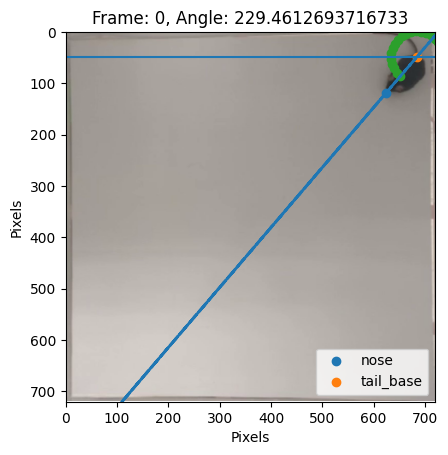

Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:30:54.351494


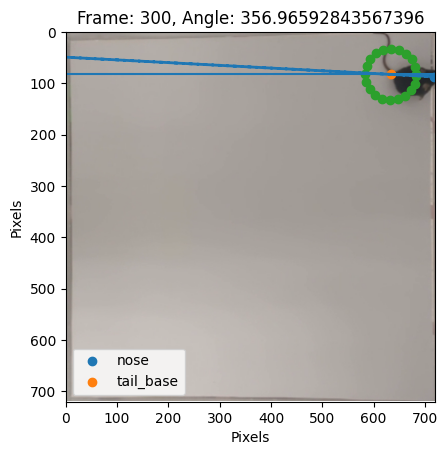

Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:30:54.512205


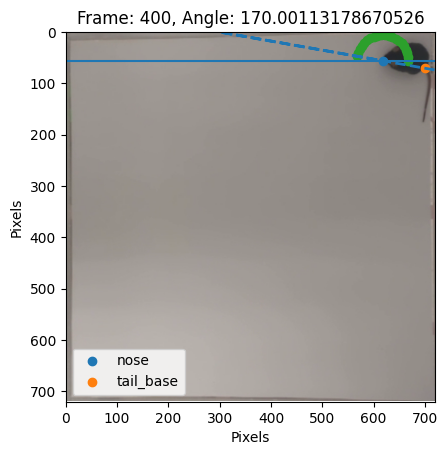

Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:30:54.675135


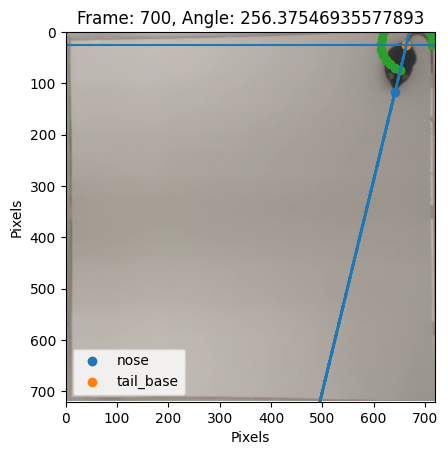

Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:30:54.833619


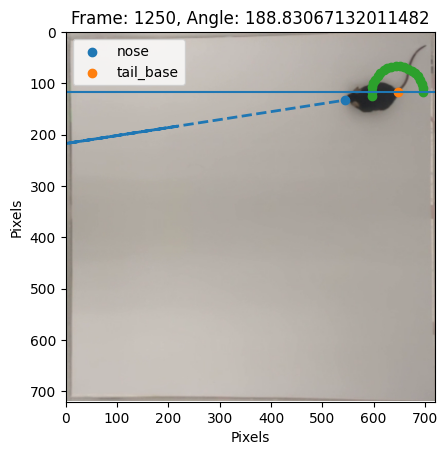

Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:30:55.002679


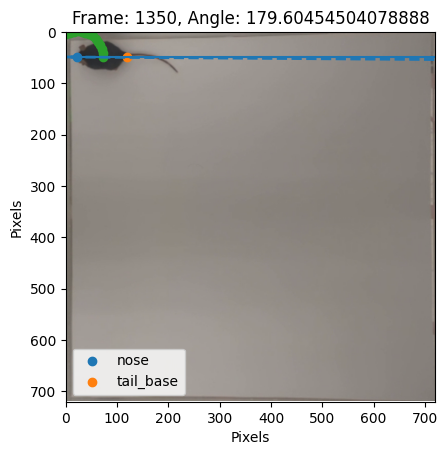

Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:30:55.157673


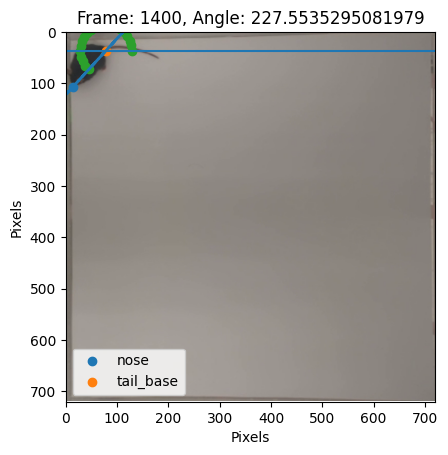

Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:30:55.348773


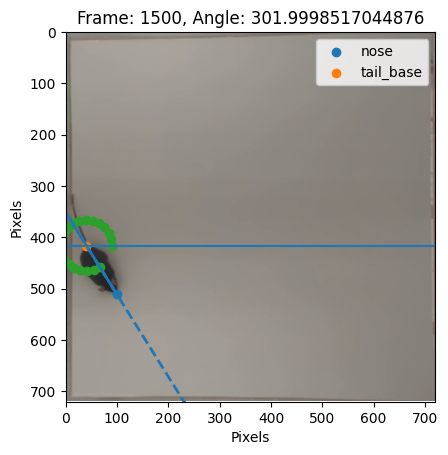

Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:30:55.507815


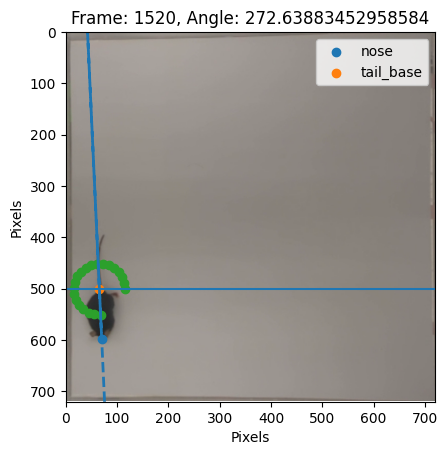

Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:30:55.663102


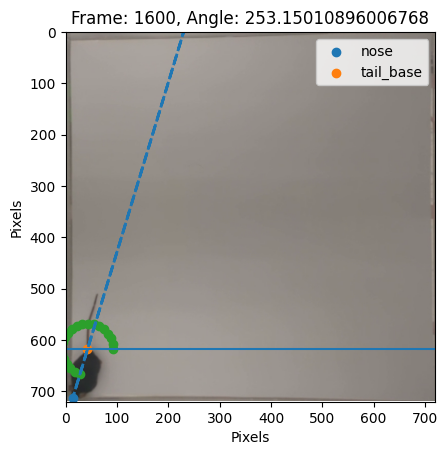

Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:30:55.811998


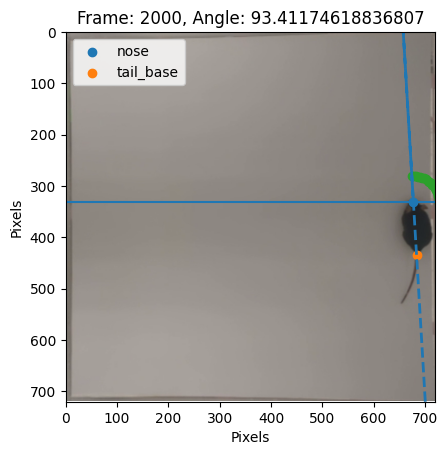

In [5]:
# This is a set of test frame indexes showing different orientations of the mouse
test_frames = [0, 300, 400, 700, 1250, 1350, 1400, 1500, 1520, 1600, 2000]

# Let's set up cv2 for visualizing the frames 
video_path = "/home/munteanlab/Desktop/code/data_dir/mutant_clonidine/554479_L_D1CreKctd_clonidine.mp4"
im_path = "/home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png"

# create video capture object
# the camera is "pointed at" the video at video_path
print(f"{datetime.datetime.now()}\nCreating VideoCapture Object...")
cap = cv2.VideoCapture(video_path)

# specify points of interest
forward_point = "nose"
back_point = "tail_base"
forward_key_x = forward_point + "_x"
forward_key_y = forward_point + "_y"
back_key_x = back_point + "_x"
back_key_y = back_point + "_y"

for tf in test_frames:
    print(f"Calculating angles...")
    # First, find the angle
    # extract points
    forward_x = list(extracted.loc[:, forward_key_x])[tf]
    forward_y = list(extracted.loc[:, forward_key_y])[tf]
    back_x = list(extracted.loc[:, back_key_x])[tf]
    back_y = list(extracted.loc[:, back_key_y])[tf]

    angle, slope, xint = orientation_radians(forward_x, forward_y, back_x, back_y, 720)
    
    
    # CAP_PROP_POS_FRAMES specifies the next frame to be captured 
    # we change this value to the frame of interest at 'frame_index'
    cap.set(cv2.CAP_PROP_POS_FRAMES, tf)

    # cap.read() captures the specified frame
    ret, frame = cap.read()
    print(f"Frame captured?: {ret}")

    # imwrite will write the image to the specified path
    print(f"Saving image to {im_path}...")
    ret = cv2.imwrite(im_path, frame)
    print(f"Image saved?: {ret}")

    # Matplotlib is used to display the captured frame
    print(f"Displaying image...\n{datetime.datetime.now()}")
    
    
    # Let's plot the angle 
    # these lists will store the points for plotting an arc
    angle_x = []; angle_y = [];
    radius = 50
    arc_points = 20 # we'll use this many points to construct the arc
    step_size = angle/arc_points
    for ii in range(0, (arc_points + 1)):
        phi = ii*step_size
        angle_x.append(radius*math.cos(phi))
        angle_y.append(radius*math.sin(phi))
    
    # center the circle
    if (forward_y < back_y):
        # center at forward
        angle_x = [(x + forward_x) for x in angle_x]
        angle_y = [(y + forward_y) for y in angle_y]
        angle_y = [(((y - forward_y) * -1) + forward_y) for y in angle_y]
        horizontal = forward_y
        
    elif (forward_y > back_y):
        # center at back
        angle_x = [(x + back_x) for x in angle_x]
        angle_y = [(y + back_y) for y in angle_y]
        angle_y = [(((y - back_y) * -1) + back_y) for y in angle_y]
        horizontal = back_y

    # Lets plot the line
    yint = (-1*slope*forward_x) + forward_y
    hypotenuse_x = [xint, yint, 0, forward_x]
    hypotenuse_y = [((slope*x) + yint) for x in hypotenuse_x]

    image = mpimg.imread(im_path) 
    fig, ax = plt.subplots()
    ax.set(xlim=[0, 720], ylim=[0,720])
    
    # put image on the plot
    plt.imshow(image);

    # Project the points of interest onto the plot
    ax.scatter(forward_x, forward_y, label=forward_point)
    ax.scatter(back_x, back_y, label=back_point)

    # plot geometry
    ax.scatter(angle_x, angle_y)
    ax.plot(hypotenuse_x, hypotenuse_y, linestyle='dashed', linewidth=2)
    ax.axhline(y=horizontal)
    
    # plot formatting
    ax.set_xlabel("Pixels")
    ax.set_ylabel("Pixels")
    plt.title(f"Frame: {tf}, Angle: {angle*(180/math.pi)}")
    plt.legend()
    # invert the y-axis
    ax.invert_yaxis()
    # show plot
    plt.show()

### Between two points horizontally

2025-05-21 06:32:45.722203
Creating VideoCapture Object...
Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:32:45.750673


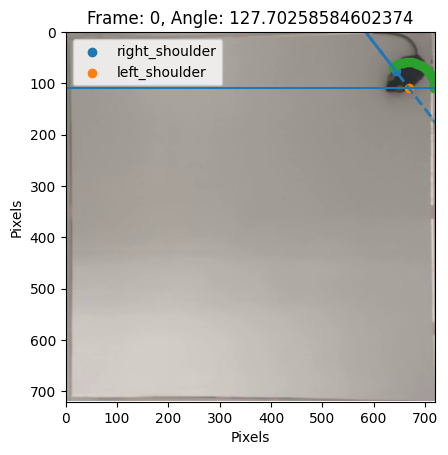

Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:32:45.906678


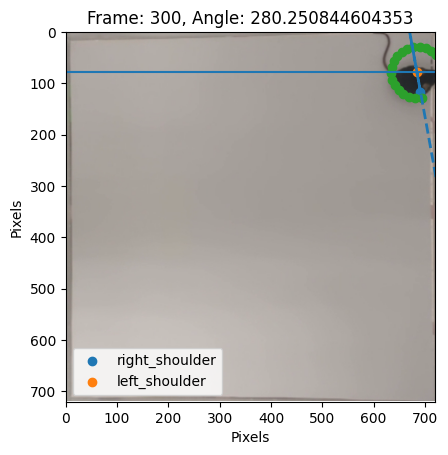

Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:32:46.061925


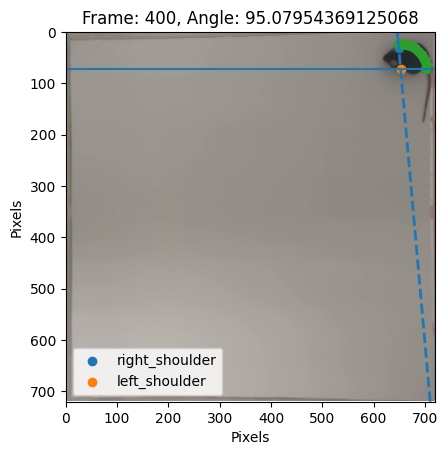

Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:32:46.217693


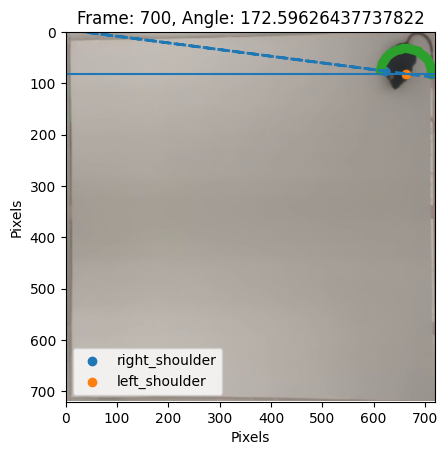

Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:32:46.371531


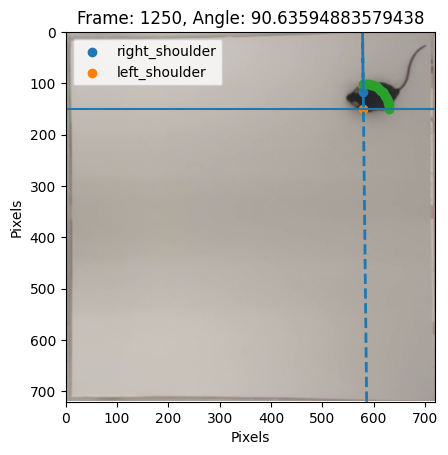

Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:32:46.537739


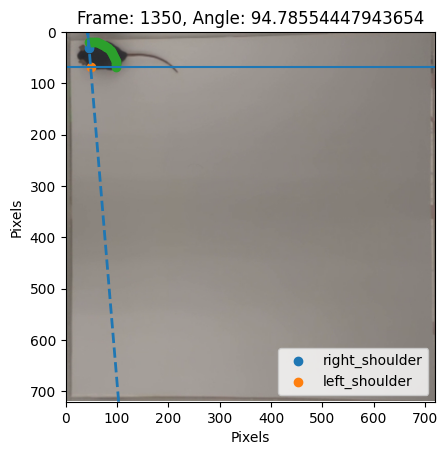

Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:32:46.698651


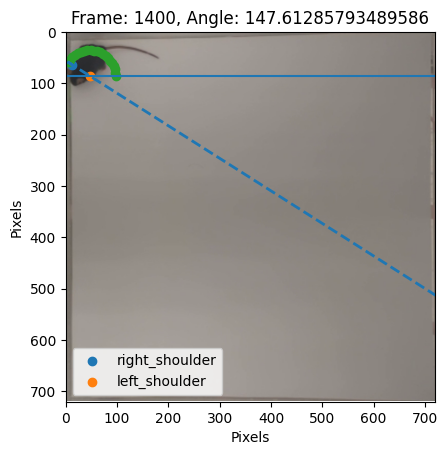

Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:32:46.859202


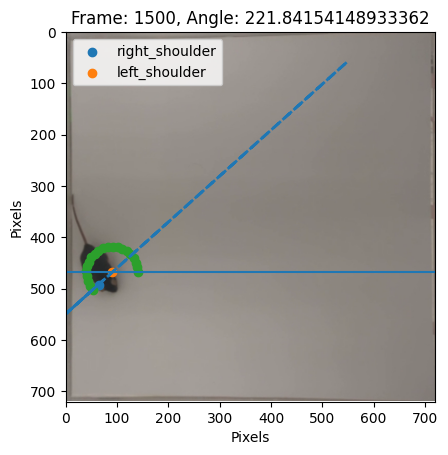

Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:32:47.021302


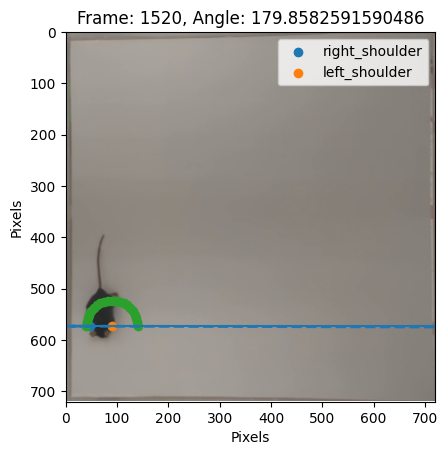

Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:32:47.178882


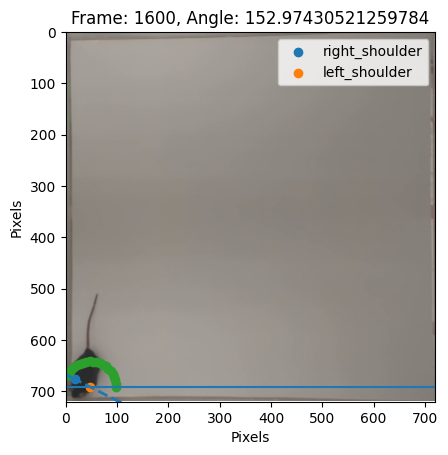

Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:32:47.331266


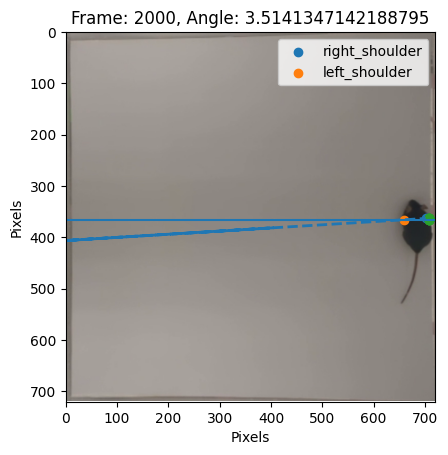

In [7]:
# This is a set of test frame indexes showing different orientations of the mouse
test_frames = [0, 300, 400, 700, 1250, 1350, 1400, 1500, 1520, 1600, 2000]

# Let's set up cv2 for visualizing the frames 
video_path = "/home/munteanlab/Desktop/code/data_dir/mutant_clonidine/554479_L_D1CreKctd_clonidine.mp4"
im_path = "/home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png"

# create video capture object
# the camera is "pointed at" the video at video_path
print(f"{datetime.datetime.now()}\nCreating VideoCapture Object...")
cap = cv2.VideoCapture(video_path)

# specify points of interest
right_point = "right_shoulder"
left_point  = "left_shoulder"
right_key_x = right_point + "_x"
right_key_y = right_point + "_y"
left_key_x  = left_point  + "_x"
left_key_y  = left_point  + "_y"

for tf in test_frames:
    print(f"Calculating angles...")
    # First, find the angle
    # extract points
    right_x = list(extracted.loc[:, right_key_x])[tf]
    right_y = list(extracted.loc[:, right_key_y])[tf]
    left_x = list(extracted.loc[:, left_key_x])[tf]
    left_y = list(extracted.loc[:, left_key_y])[tf]

    angle, slope, xint = orientation_horizontal(right_x, right_y, left_x, left_y, 720)
    
    
    # CAP_PROP_POS_FRAMES specifies the next frame to be captured 
    # we change this value to the frame of interest at 'frame_index'
    cap.set(cv2.CAP_PROP_POS_FRAMES, tf)

    # cap.read() captures the specified frame
    ret, frame = cap.read()
    print(f"Frame captured?: {ret}")

    # imwrite will write the image to the specified path
    print(f"Saving image to {im_path}...")
    ret = cv2.imwrite(im_path, frame)
    print(f"Image saved?: {ret}")

    # Matplotlib is used to display the captured frame
    print(f"Displaying image...\n{datetime.datetime.now()}")

    # Let's plot the angle 
    # these lists will store the points for plotting an arc
    angle_x = []; angle_y = [];
    radius = 50
    arc_points = 20 # we'll use this many points to construct the arc
    step_size = angle/arc_points
    for ii in range(0, (arc_points + 1)):
        phi = ii*step_size
        angle_x.append(radius*math.cos(phi))
        angle_y.append(radius*math.sin(phi))
    angle_x = [(x+left_x) for x in angle_x]
    angle_y = [(y+left_y) for y in angle_y]

    angle_y = [(((y_pos - left_y) * -1) + left_y) for y_pos in angle_y]

    # Lets plot the line
    yint = (-1*slope*right_x) + right_y
    hypotenuse_x = [xint, yint, 0, right_x]
    hypotenuse_y = [((slope*x) + yint) for x in hypotenuse_x]


    
    image = mpimg.imread(im_path)
    fig, ax = plt.subplots()
    ax.set(xlim=[0, 720], ylim=[0,720])

    # Put the image on the plot
    plt.imshow(image);

    # Project the points of interest onto the plot
    ax.scatter(right_x, right_y, label=right_point)
    ax.scatter(left_x, left_y, label=left_point)

    # plot geometry
    ax.scatter(angle_x, angle_y)
    ax.plot(hypotenuse_x, hypotenuse_y, linestyle='dashed', linewidth=2)
    ax.axhline(y=left_y)

    # plot formatting
    ax.set_xlabel("Pixels")
    ax.set_ylabel("Pixels")
    plt.title(f"Frame: {tf}, Angle: {angle*(180/math.pi)}")
    plt.legend()
    # show the plot'
    ax.invert_yaxis()
    plt.show()


## Animate the Plot

2025-05-21 06:34:14.575099
Creating VideoCapture Object...
Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:34:14.607601
Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:34:14.647005
Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:34:14.673259
Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:34:14.702004
Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/veloci

MovieWriter PillowWriter unavailable; using Pillow instead.


Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:34:17.928245
Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:34:17.973241
Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:34:18.001998
Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025-05-21 06:34:18.031895
Calculating angles...
Frame captured?: True
Saving image to /home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png...
Image saved?: True
Displaying image...
2025

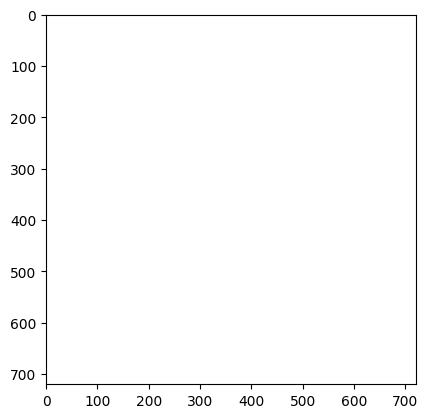

In [8]:
# This is a set of test frame indexes showing different orientations of the mouse
test_frames = list(range(0, 100))

# Let's set up cv2 for visualizing the frames 
video_path = "/home/munteanlab/Desktop/code/data_dir/mutant_clonidine/554479_L_D1CreKctd_clonidine.mp4"
im_path = "/home/munteanlab/Desktop/code/data_dir/velocity_testing_12192024/test_frame.png"

# create video capture object
# the camera is "pointed at" the video at video_path
print(f"{datetime.datetime.now()}\nCreating VideoCapture Object...")
cap = cv2.VideoCapture(video_path)

# specify points of interest
forward_point = "nose"
back_point = "tail_base"
forward_key_x = forward_point + "_x"
forward_key_y = forward_point + "_y"
back_key_x = back_point + "_x"
back_key_y = back_point + "_y"

fig, ax = plt.subplots()
ax.set(xlim=[0, 720], ylim=[0,720])
ax.invert_yaxis()
# set up camera
camera = Camera(fig)

for tff in test_frames:    
    
    tf = tff*5 # take a snap every 5 frames
    
    print(f"Calculating angles...")
    # First, find the angle
    # extract points
    forward_x = list(extracted.loc[:, forward_key_x])[tf]
    forward_y = list(extracted.loc[:, forward_key_y])[tf]
    back_x = list(extracted.loc[:, back_key_x])[tf]
    back_y = list(extracted.loc[:, back_key_y])[tf]

    angle, slope, xint = orientation_radians(forward_x, forward_y, back_x, back_y, 720)
    
    
    # CAP_PROP_POS_FRAMES specifies the next frame to be captured 
    # we change this value to the frame of interest at 'frame_index'
    cap.set(cv2.CAP_PROP_POS_FRAMES, tf)

    # cap.read() captures the specified frame
    ret, frame = cap.read()
    print(f"Frame captured?: {ret}")

    # imwrite will write the image to the specified path
    print(f"Saving image to {im_path}...")
    ret = cv2.imwrite(im_path, frame)
    print(f"Image saved?: {ret}")

    # Matplotlib is used to display the captured frame
    print(f"Displaying image...\n{datetime.datetime.now()}")
    
    
    # Let's plot the angle 
    # these lists will store the points for plotting an arc
    angle_x = []; angle_y = [];
    radius = 50
    arc_points = 20 # we'll use this many points to construct the arc
    step_size = angle/arc_points
    for ii in range(0, (arc_points + 1)):
        phi = ii*step_size
        angle_x.append(radius*math.cos(phi))
        angle_y.append(radius*math.sin(phi))
    
    # center the circle
    if (forward_y < back_y):
        # center at forward
        angle_x = [(x + forward_x) for x in angle_x]
        angle_y = [(y + forward_y) for y in angle_y]
        angle_y = [(((y - forward_y) * -1) + forward_y) for y in angle_y]
        horizontal = forward_y
        
    elif (forward_y > back_y):
        # center at back
        angle_x = [(x + back_x) for x in angle_x]
        angle_y = [(y + back_y) for y in angle_y]
        angle_y = [(((y - back_y) * -1) + back_y) for y in angle_y]
        horizontal = back_y

    # Lets plot the line
    yint = (-1*slope*forward_x) + forward_y
    hypotenuse_x = [xint, yint, 0, forward_x]
    hypotenuse_y = [((slope*x) + yint) for x in hypotenuse_x]

    image = mpimg.imread(im_path) 
    # put image on the plot
    ax.imshow(image, origin='lower');

    # Project the points of interest onto the plot
    ax.scatter(forward_x, forward_y, label=forward_point, c='blue')
    ax.scatter(back_x, back_y, label=back_point, c='orange')

    # plot geometry
    ax.scatter(angle_x, angle_y, c='green')
    ax.plot(hypotenuse_x, hypotenuse_y, linestyle='dashed', linewidth=2, c='red')
    ax.axhline(y=horizontal, c='pink')
    
    camera.snap()

animation = camera.animate()
animation.save('test_gif.gif', writer="PillowWriter", fps=30)